In [3]:
# Import Statements
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import pandas as pd
import os
import struct

In [4]:
# Load Digits Dataset (Example)
ds = load_digits()

# Normalize Input
X = ds.data / 16.0 - 0.5
y = ds.target

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## **TwoLayerPerceptron (TLP) With Correct Version**

In [91]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [92]:
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
    

In [93]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2

In [95]:
vals = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.01, # poor starting learning rate!!
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn_quad = TLPMiniBatch(**vals)
nn_cross = TLPMiniBatchCrossEntropy(**vals)

%time nn_cross.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_quad.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
print("Done")

Epoch: 10/20

CPU times: total: 172 ms
Wall time: 424 ms


Epoch: 20/20

CPU times: total: 125 ms
Wall time: 386 ms
Done


In [96]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Cross Entropy Loss :
Resubstitution acc: 0.9526791927627001
Validation acc: 0.9444444444444444
MSE Loss :
Resubstitution acc: 0.8747390396659708
Validation acc: 0.8777777777777778


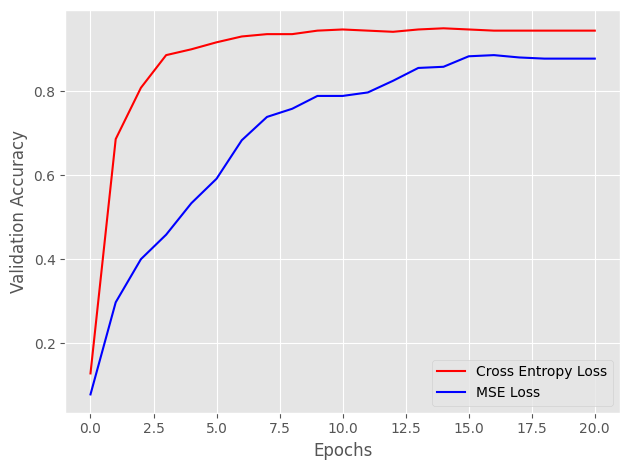

In [97]:
print_result(nn_cross,X_train,y_train,X_test,y_test,title="Cross Entropy Loss",color="red")
print_result(nn_quad,X_train,y_train,X_test,y_test,title="MSE Loss",color="blue")

plt.show()

In [98]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2

Epoch: 10/20

CPU times: total: 31.2 ms
Wall time: 396 ms


Epoch: 20/20

CPU times: total: 156 ms
Wall time: 412 ms
Traditional :
Resubstitution acc: 0.7807933194154488
Validation acc: 0.8055555555555556
Glorot Initial :
Resubstitution acc: 0.8100208768267223
Validation acc: 0.8


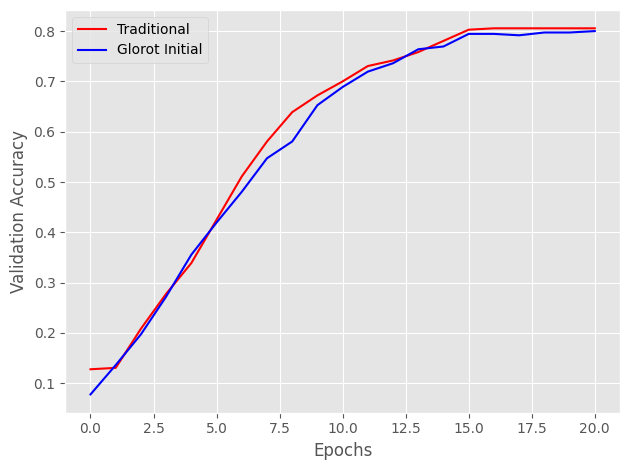

In [99]:
vals['epochs'] = 20
vals['eta'] = 0.001

nn_tradit = TLPMiniBatchCrossEntropy(**vals)
nn_better = TLPBetterInitial(**vals)

%time nn_tradit.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
%time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

print_result(nn_tradit,X_train,y_train,X_test,y_test,title="Traditional",color="red")
print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
plt.show()

Epoch: 75/75

CPU times: total: 594 ms
Wall time: 1.46 s
Long Run :
Resubstitution acc: 0.9617258176757133
Validation acc: 0.9611111111111111


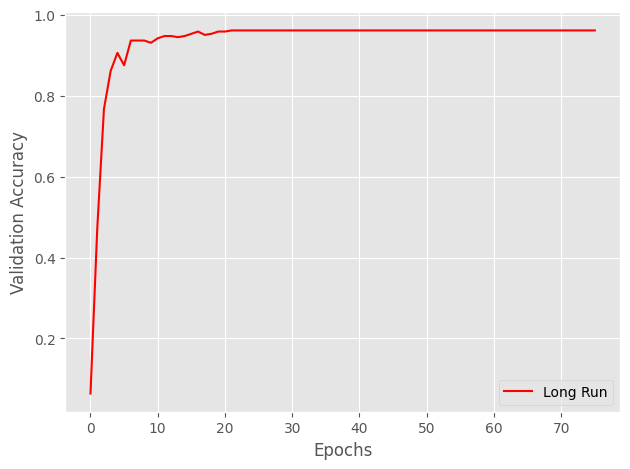

In [100]:
# just for fun, let's look at the output of what happens when we let our system loose
# these values have been hand tuned
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.005, 
         'alpha':0.1, 'decrease_const':0.1,
         'decrease_iter':20,
         'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

nn_long_sigmoid = TLPBetterInitial(**vals)

%time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

# **MultiLayerPerceptron (MLP) Implementation**

In [1]:
# =================
# Import Statements
# =================

# Standard Stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Sklearn Imports
from scipy.special import expit
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ==========================
# MultiLayerPerceptron Class
# ==========================

class MultiLayerPerceptron:

    def __init__(self, layers, C = 0.0, epochs = 500, eta = 0.001, random_state = None, 
                 alpha = 0.1, decrease_const = 0.0, shuffle = True, minibatches = 1):
        """
        Initialize The Multi Layer Perceptron (MLP) Classifier.

        Parameters, Attributes, Descriptions:
        - layers:           List Of Integers,   Representing No. Units In Each MLP Layer.
        - C:                Float,              Regularization Parameter.
        - epochs:           Int,                No. Iterations Over Entire Dataset.
        - eta:              Float,              Learning Rate.
        - random_state:     Int,                Seed For Random Weight Initialization, Shuffling.
        - alpha:            Float,              Momentum Coefficient To Improve Convergence.
        - decrease_const:   Float,              Reduces Learning Rate Every Epoch.
        - shuffle:          Bool,               Whether To Shuffle Dataset Every Epoch.
        - minibatches:      Int,                No. Minibatches To Split Dataset Into.
        """

        # Seed For Reproducability
        np.random.seed(random_state)

        # Store Architecture, Regularization, Optimization Parameters
        self.layers = layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    # ===============
    # Utility Methods
    # ===============

    @staticmethod
    def _encode_labels(y):
        """ Encode Labels Into One-Hot Representation """
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """ Use Scipy Expit To Avoid Overflow (Sigmoid Activation Function) """
        return expit(z)
    
    def _L2_reg(self):
        """ Compute L2 Regularization Cost """
        return self.l2_C * np.sum([np.mean(w ** 2) for w in self.W])
    
    def _cost(self, A, Y_enc):
        """ Compute Objective Function Value Using Cross-Entropy Loss """
        m = Y_enc.shape[1]

        # Compute Cross-Entropy Loss (Negative Log Likelihood)
        cost = -1 / m * np.sum(Y_enc * np.log(A[-1]))
        L2_term = self._L2_reg()
        return cost + L2_term

    # ====================
    # Feed Forward Methods
    # ====================

    # Initialize Weight, Bias Matrices
    def _initialize_weights(self):

        # Initialize Weights, Biases
        W = []
        b = []
        layer_input = self.n_features_

        # Initialize Weights For Hidden Layers
        for layer in self.layers:

            # Glorot (Xavier) Initialization
            init_bound = np.sqrt(6. / (layer_input + layer))
            W.append(np.random.uniform(-init_bound, init_bound, (layer, layer_input)))
            b.append(np.zeros((layer, 1)))
            layer_input = layer
        
        # Initialize Weights For Output Layer
        init_bound = np.sqrt(6. / (layer_input + self.n_output_))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_output_, layer_input)))
        b.append(np.zeros((self.n_output_, 1)))

        # Return Weights, Biases
        return W, b
    
    # Compute Forward Pass Through Network
    def _feedforward(self, X):

        # Initialize Activations
        A = [X.T]
        Z = []

        # Compute Activations For All Layers
        for w, b in zip(self.W, self.b):
            z = w @ A[-1] + b
            Z.append(z)
            a = self._sigmoid(z)
            A.append(a)

        # Compute Softmax Activations For Output Layer
        A[-1] = np.exp(Z[-1]) / np.sum(np.exp(Z[-1]), axis = 0)
        return A, Z
    
    # Compute Gradient Using Backpropagation
    def _get_gradient(self, A, Z, Y_enc):

        # Start From Output Layer
        V = [A[-1] - Y_enc]

        # Compute Pre-Activation Gradient For All Layers (Reversed => Backpropagation)
        for i in reversed(range(1, len(self.layers) + 1)):
            v = A[i] * (1 - A[i]) * (self.W[i].T @ V[-1])
            V.append(v)
        V = V[::-1]

        # Compute Gradients For All Weight Matrices, Bias Vectors
        gradW = []
        gradb = []
        for i in range(len(V)):
            gradW.append(V[i] @ A[i].T)
            gradb.append(np.sum(V[i], axis = 1, keepdims = True))
        return gradW, gradb
    
    # ==============
    # Public Methods
    # ==============

    # Train The Neural Network
    def fit(self, X, y, print_progress=0):
        """ Learn Weights From Training Data """
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        self.cost_ = []

        # Store Gradient Magnitudes
        self.grad_magnitudes_ = []
        
        # Run Loop For Each Epoch
        progress_interval = max(1, self.epochs // print_progress)
        for i in range(self.epochs):

            # Print Current Progress (Padding For Fixed Output)
            if print_progress > 0 and (i + 1) % progress_interval == 0:
                msg = '\rEpoch: {}/{}'.format(i + 1, self.epochs)
                sys.stderr.write(msg + ' ' * (20 - len(msg)))
                sys.stderr.flush()
            
            # Shuffle Dataset For Method
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # Split Data Into Minibatches For Minibatch Gradient Descent
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)

            # Store Costs, Gradient Magnitudes For This Epoch
            mini_cost = []
            epoch_grads = []

            # Perform Method
            for idx in mini:
                A, Z = self._feedforward(X_data[idx])
                cost = self._cost(A, Y_enc[:, idx])
                mini_cost.append(cost)

                # Vectorized Gradient Computation
                gradW, gradb = self._get_gradient(A = A, Z = Z, Y_enc = Y_enc[:, idx])

                # Compute Gradient Magnitudes Using L2 Norm
                grad_mags = [np.linalg.norm(gw) for gw in gradW]
                epoch_grads.append(grad_mags)
                for w, grad_w, b, grad_b in zip(self.W, gradW, self.b, gradb):
                    w -= self.eta * grad_w
                    b -= self.eta * grad_b
            self.cost_.append(mini_cost)

            # Store Average Gradient Magnitudes For Each Layer, For Each Epoch (Over Minibatches)
            self.grad_magnitudes_.append(np.mean(epoch_grads, axis = 0))
            
        return self

    def predict(self, X):
        """ Predict Class Labels """
        A, _ = self._feedforward(X)
        y_pred = np.argmax(A[-1], axis = 0)
        return y_pred

# **MultiLayerPerceptron (MLP) Testing**

In [11]:
# Initialize Hyperparameters (Can Be Changed):
vals = { 
    'C':                0.0, 
    'epochs':           500, 
    'eta':              0.001,
    'random_state':     1,
    'alpha':            0.01,
    'shuffle':          True,
    'minibatches':      len(X_train) / 32
}

# Define Layer Configurations For Testing (Can Be Changed):
layer_configs = [
    [50],           # Three Layers: Input + 1 Hidden + Output
    [50, 50],       # Four Layers: Input + 2 Hidden + Output
    [50, 50, 50]    # Five Layers: Input + 3  Hidden + Output
]

# Initialize Empty Dictionaries => Store Results, Gradient Magnitudes, Costs
results = {}
gradient_magnitudes = {}
avg_costs = {}

# Loop Through Each Layer Configuration, Test MLP Classifier
for config in layer_configs:

    # Initialize MLP With Current Configuration, Values
    nn = MultiLayerPerceptron(layers = config, **vals)

    # Fit, Predict, Compute Accuracy
    nn.fit(X_train, y_train, print_progress = 10)
    yhat = nn.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    results[tuple(config)] = accuracy
    gradient_magnitudes[tuple(config)] = nn.grad_magnitudes_
    avg_costs[tuple(config)] = [np.mean(x) for x in nn.cost_]

# Print Results:
print("\nLayer, Accuracy Results:")
for config, accuracy in results.items():
    print(config, accuracy)

Epoch: 500/500     


Layer, Accuracy Results:
(50,) 0.9638888888888889
(50, 50) 0.9722222222222222
(50, 50, 50) 0.9444444444444444


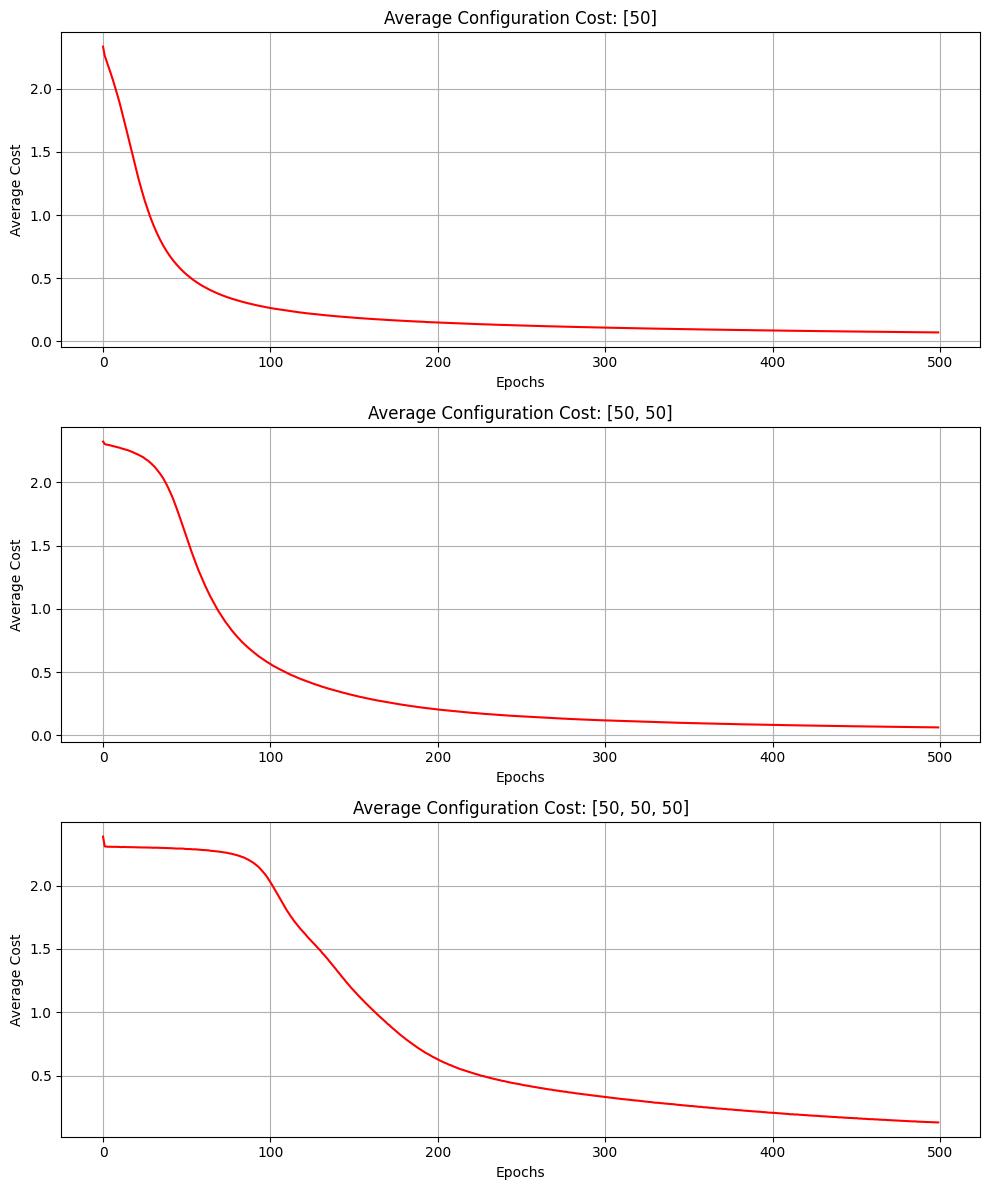

In [12]:
# Plotting Average Costs Against Epochs For Each Configuration
fig, axes = plt.subplots(nrows = len(layer_configs), figsize = (10, 12))

# Plot Loss Function For Each Configuration
for ax, config in zip(axes, layer_configs):
    cost_avgs = avg_costs[tuple(config)]
    ax.plot(range(len(cost_avgs)), cost_avgs, color = 'red')
    ax.set_title(f'Average Configuration Cost: {config}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Cost')
    ax.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

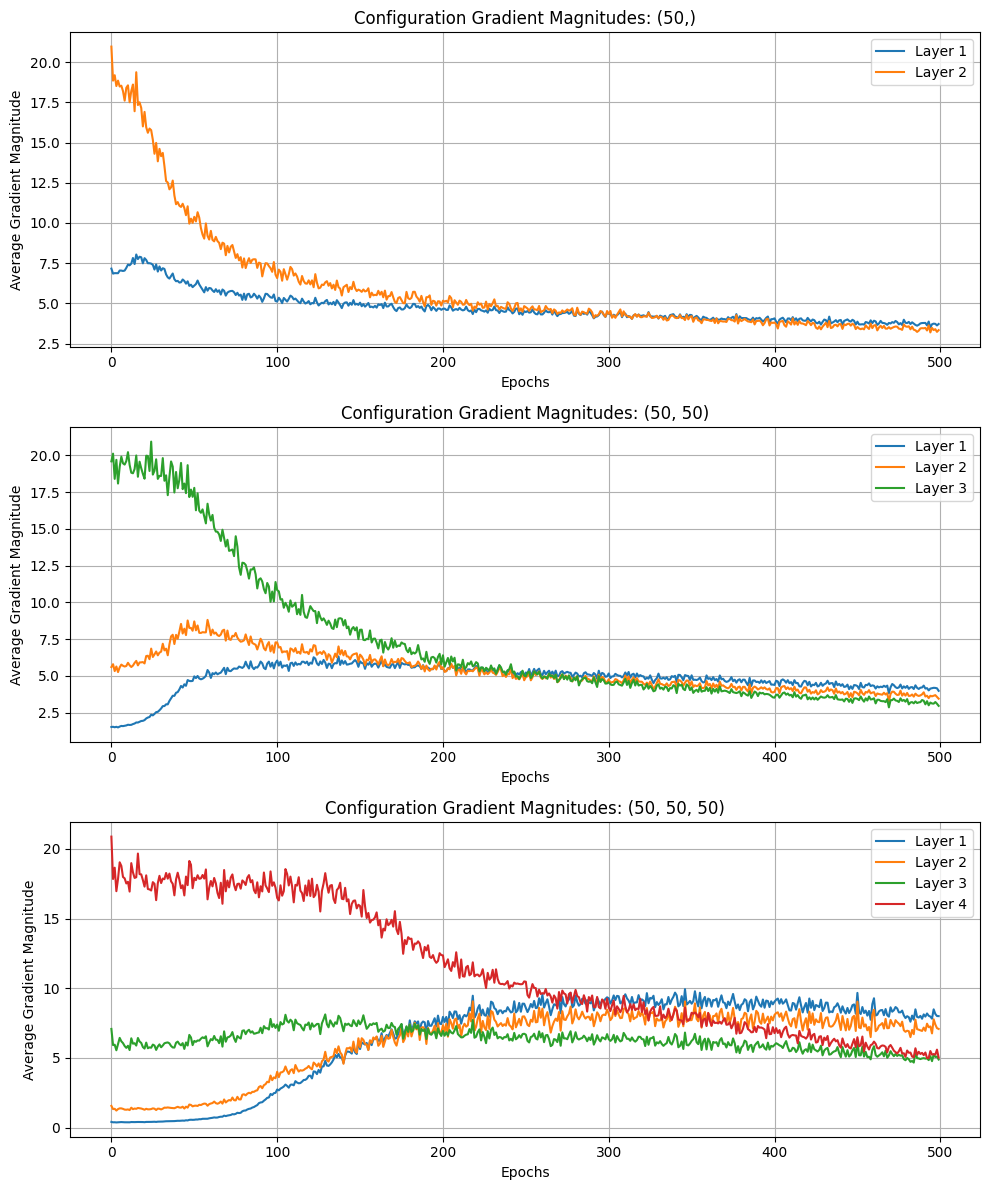

In [13]:
# Plotting Gradient Magnitudes Against Epochs For Each Configuration
fig, axes = plt.subplots(nrows = len(layer_configs), figsize = (10, 12))

# Plot Gradient Magnitudes For Each Configuration
for ax, (config, grads) in zip(axes, gradient_magnitudes.items()):
    grads = np.array(grads)
    for i in range(grads.shape[1]):
        ax.plot(grads[:, i], label = f'Layer {i+1}')
    ax.set_title(f'Configuration Gradient Magnitudes: {config}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Magnitude')
    ax.legend()
    ax.grid(True)

# Show Plot
plt.tight_layout()
plt.show()

# **Adaptive MultiLayerPerceptron (MLP) Implementation**

In [79]:
class MultiLayerPerceptronAdaptive(MultiLayerPerceptron):
    def __init__(self, layers, adaptive=None, C=0.0, epochs=500, eta=0.001, 
                 beta1=0.9, beta2=0.999, epsilon=1e-7, random_state=None, 
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        super().__init__(layers, C, epochs, eta, random_state, alpha, decrease_const, shuffle, minibatches)
        self.adaptive = adaptive
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def _initialize_weights(self):
        W, b = super()._initialize_weights()
        if self.adaptive:
            self.M_W = [np.zeros(w.shape) for w in W]
            self.M_b = [np.zeros(bi.shape) for bi in b]
            self.S_W = [np.zeros(w.shape) for w in W]
            self.S_b = [np.zeros(bi.shape) for bi in b]
        return W, b
    
    def _update_weights(self, gradW, gradb, t):
        for i, (w, grad_w, b, grad_b) in enumerate(zip(self.W, gradW, self.b, gradb)):

            if self.adaptive == "rmsprop":
                self.S_W[i] = self.beta2 * self.S_W[i] + (1 - self.beta2) * grad_w**2
                w -= self.eta * grad_w / (np.sqrt(self.S_W[i]) + self.epsilon)
                
                self.S_b[i] = self.beta2 * self.S_b[i] + (1 - self.beta2) * grad_b**2
                b -= self.eta * grad_b / (np.sqrt(self.S_b[i]) + self.epsilon)
            
            elif self.adaptive == "adam" or self.adaptive == "adamw":
                self.M_W[i] = self.beta1 * self.M_W[i] + (1 - self.beta1) * grad_w
                self.S_W[i] = self.beta2 * self.S_W[i] + (1 - self.beta2) * grad_w**2
                m_w_corrected = self.M_W[i] / (1 - self.beta1**t)
                s_w_corrected = self.S_W[i] / (1 - self.beta2**t)
                w -= self.eta * m_w_corrected / (np.sqrt(s_w_corrected) + self.epsilon)
                
                self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * grad_b
                self.S_b[i] = self.beta2 * self.S_b[i] + (1 - self.beta2) * grad_b**2
                m_b_corrected = self.M_b[i] / (1 - self.beta1**t)
                s_b_corrected = self.S_b[i] / (1 - self.beta2**t)
                b -= self.eta * m_b_corrected / (np.sqrt(s_b_corrected) + self.epsilon)
                
                # AdamW Added Weight Decay
                if self.adaptive == "adamw":
                    w -= self.eta * self.l2_C * w
                    b -= self.eta * self.l2_C * b
                
            else:
                w -= self.eta * grad_w
                b -= self.eta * grad_b

    def fit(self, X, y, print_progress=0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        self.cost_ = []
        self.grad_magnitudes_ = []
        
        progress_interval = max(1, self.epochs // print_progress)
        
        for i in range(self.epochs):
            if print_progress > 0 and (i+1) % progress_interval == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
                
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
                
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            epoch_grads = []
            
            for idx in mini:
                A, Z = self._feedforward(X_data[idx])
                cost = self._cost(A, Y_enc[:, idx])
                mini_cost.append(cost)
                gradW, gradb = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx])
                grad_mags = [np.linalg.norm(gw) for gw in gradW]
                epoch_grads.append(grad_mags)
                
                self._update_weights(gradW, gradb, i+1)
            
            self.cost_.append(mini_cost)
            self.grad_magnitudes_.append(np.mean(epoch_grads, axis=0))
        
        return self

In [82]:
# Testing the updated MultiLayerPerceptron with adaptive techniques
adaptive_techniques = [None, "rmsprop", "adam", "adamw"]
results_adaptive = {}
gradient_magnitudes_adaptive = {}

for technique in adaptive_techniques:
    nn = MultiLayerPerceptronAdaptive(layers=[50, 50, 50], C=0.1, epochs=100, eta=0.01, random_state=1, # THIS ETA VALUE 0.1 IS TOO HIGH, NEED 0.01
                                      minibatches=len(X_train)/32, shuffle=True, adaptive=technique)
    nn.fit(X_train, y_train, print_progress=10)
    yhat = nn.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    results_adaptive[technique] = accuracy
    gradient_magnitudes_adaptive[technique] = nn.grad_magnitudes_

results_adaptive

Epoch: 100/100

{None: 0.9694444444444444,
 'rmsprop': 0.975,
 'adam': 0.9833333333333333,
 'adamw': 0.9583333333333334}

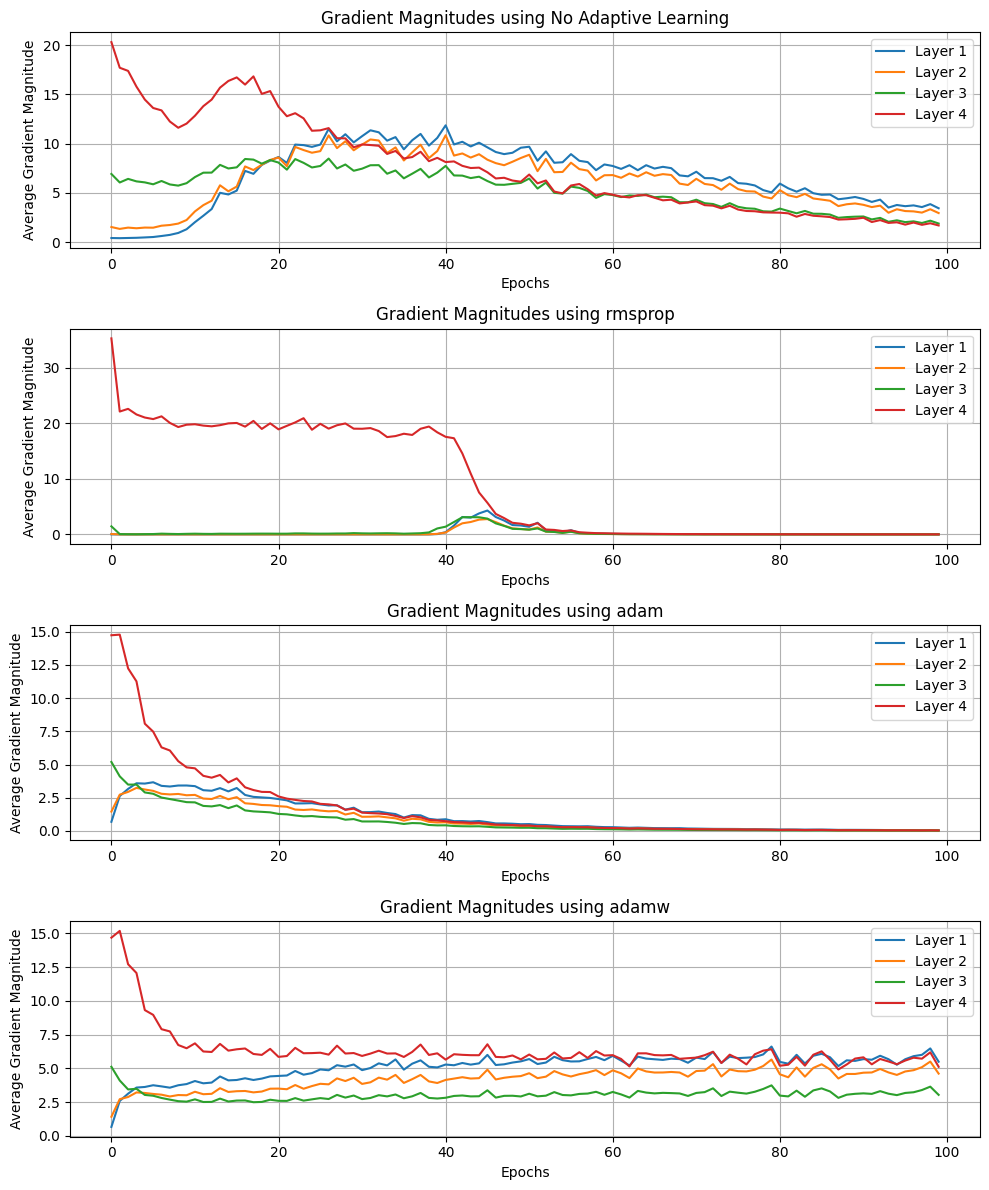

In [83]:
# Plotting the gradient magnitudes for adaptive techniques
fig, axes = plt.subplots(nrows=len(adaptive_techniques), figsize=(10, 12))

for ax, (technique, grads) in zip(axes, gradient_magnitudes_adaptive.items()):
    grads = np.array(grads)
    for i in range(grads.shape[1]):
        ax.plot(grads[:, i], label=f'Layer {i+1}')
    ax.set_title(f'Gradient Magnitudes using {technique if technique else "No Adaptive Learning"}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Magnitude')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



Adam: https://arxiv.org/pdf/1412.6980.pdf

AdamW: https://arxiv.org/pdf/1711.05101.pdf

Furthermore, each dimension of the gradient is rescaled similar to RMSprop. One key difference between Adam and RMSprop (or AdaGrad) is the fact that the moment estimates m and v are corrected for their bias towards zero. Adam is well-known for achieving good performance with little hyper-parameter tuning.

SGD+Momentum is rotation invariant whereas Adam/RMSProp/Adadelta are not. They do the best when principal directions of variations in gradient noise are axis aligned. So perhaps they are getting unlucky with the rotation

In [84]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print(sklearn_version)
# these values have been hand tuned
# sigmoid with SGD, batching, nesterov's momentum, 
# L2, adaptive learning rate
clf = MLPClassifier(hidden_layer_sizes=(50,), 
                    activation='logistic', # compare to sigmoid
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size=128, # min of 128, num_samples
                    learning_rate='adaptive', # decrease rate if loss goes up
                    learning_rate_init=0.1, # only SGD
                    power_t=0.5,    # only SGD with inverse scaling
                    max_iter=100, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

1.3.1
CPU times: total: 641 ms
Wall time: 1.45 s
Validation Acc: 0.9805555555555555


c:\Users\trevo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [85]:
# but what if we also use AdaM optimization?
# ReLU with AdaM, batching, simple momentum, 
# L2, adaptive learning rate
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer except output layer
                    solver='adam', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 128, # min of 200, num_samples
                    learning_rate='adaptive', # adapt learning? 
                    learning_rate_init=0.01, # only SGD
                    power_t=1,    # only SGD with inverse scaling of learning rate
                    max_iter=100, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',accuracy_score(yhat,y_test))

CPU times: total: 297 ms
Wall time: 1.22 s
Validation Acc: 0.9861111111111112


c:\Users\trevo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
